In [1]:
import pyomo.environ as pyo

### Pyomo basic components are:

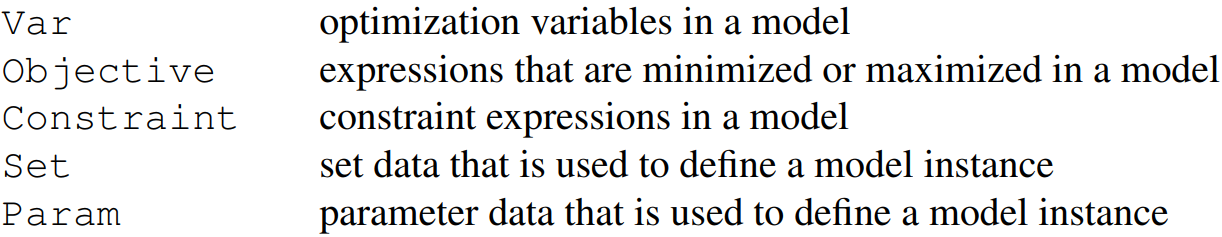

### ------------------------------------------------- example Var -------------------------------------------------

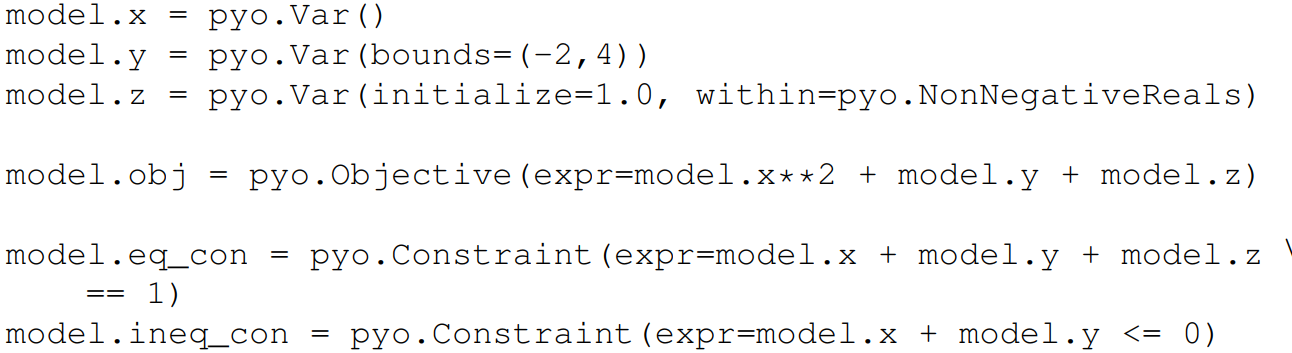

### ------------------------------------------------- example set -------------------------------------------------

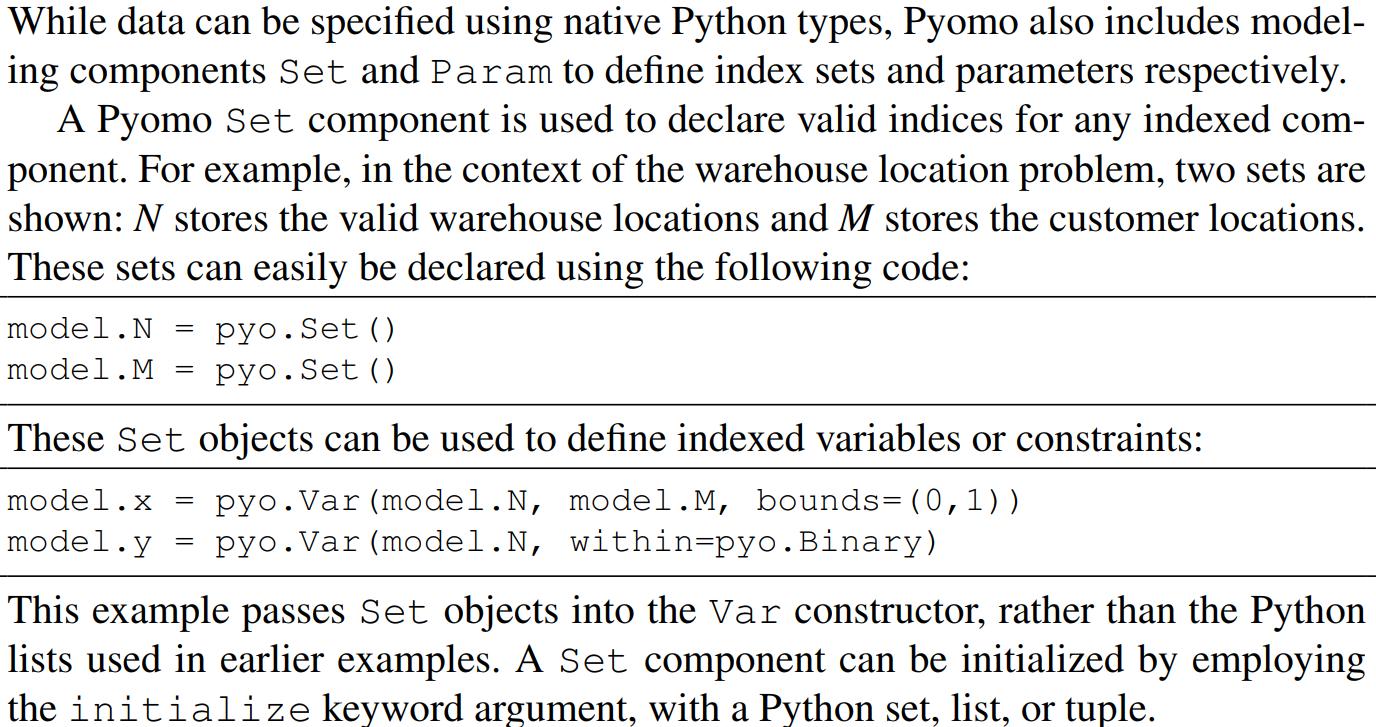

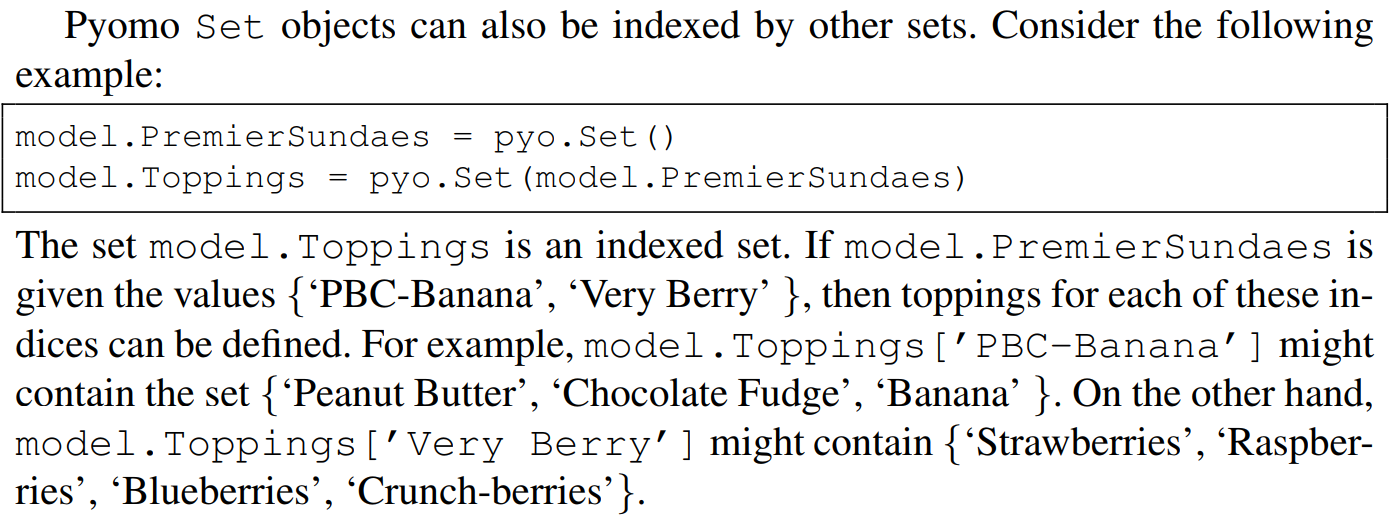

### ------------------------------------------------- example Param -------------------------------------------------

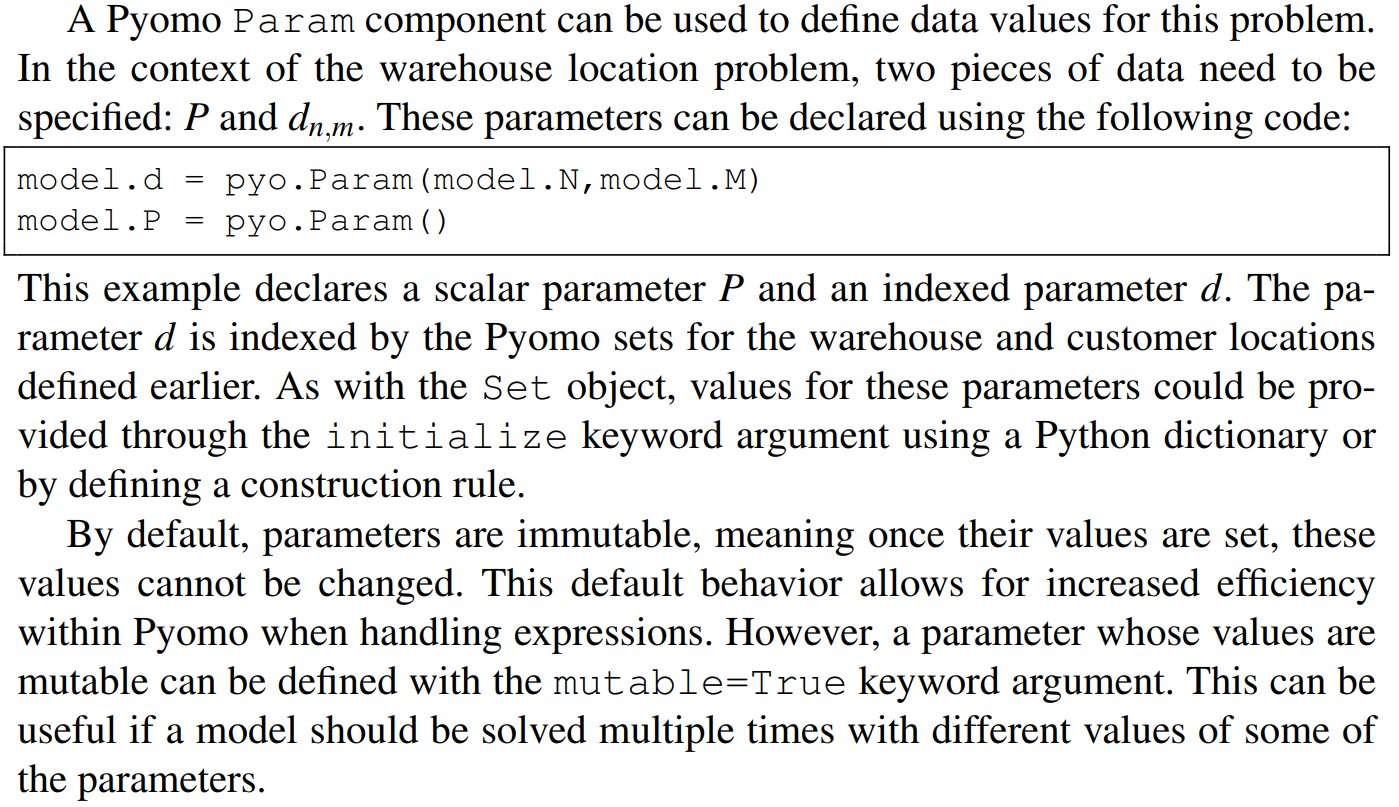

# problem description:

    o find the best location for warehouses minimizing the transportation costs.
    
    o Let N be a set of candidate warehouse locations, and let M be a set of customer locations.
    
    o For each warehouse n, the cost of delivering product to customer m is given by d_n,m.
    
    o The binary variables y_n are used to define whether or not a warehouse should be built, where y_n is 1 if warehouse n       is selected and 0 otherwise.
    
    o The variable x_n,m indicates the fraction of demand for customer m that is served by warehouse n.

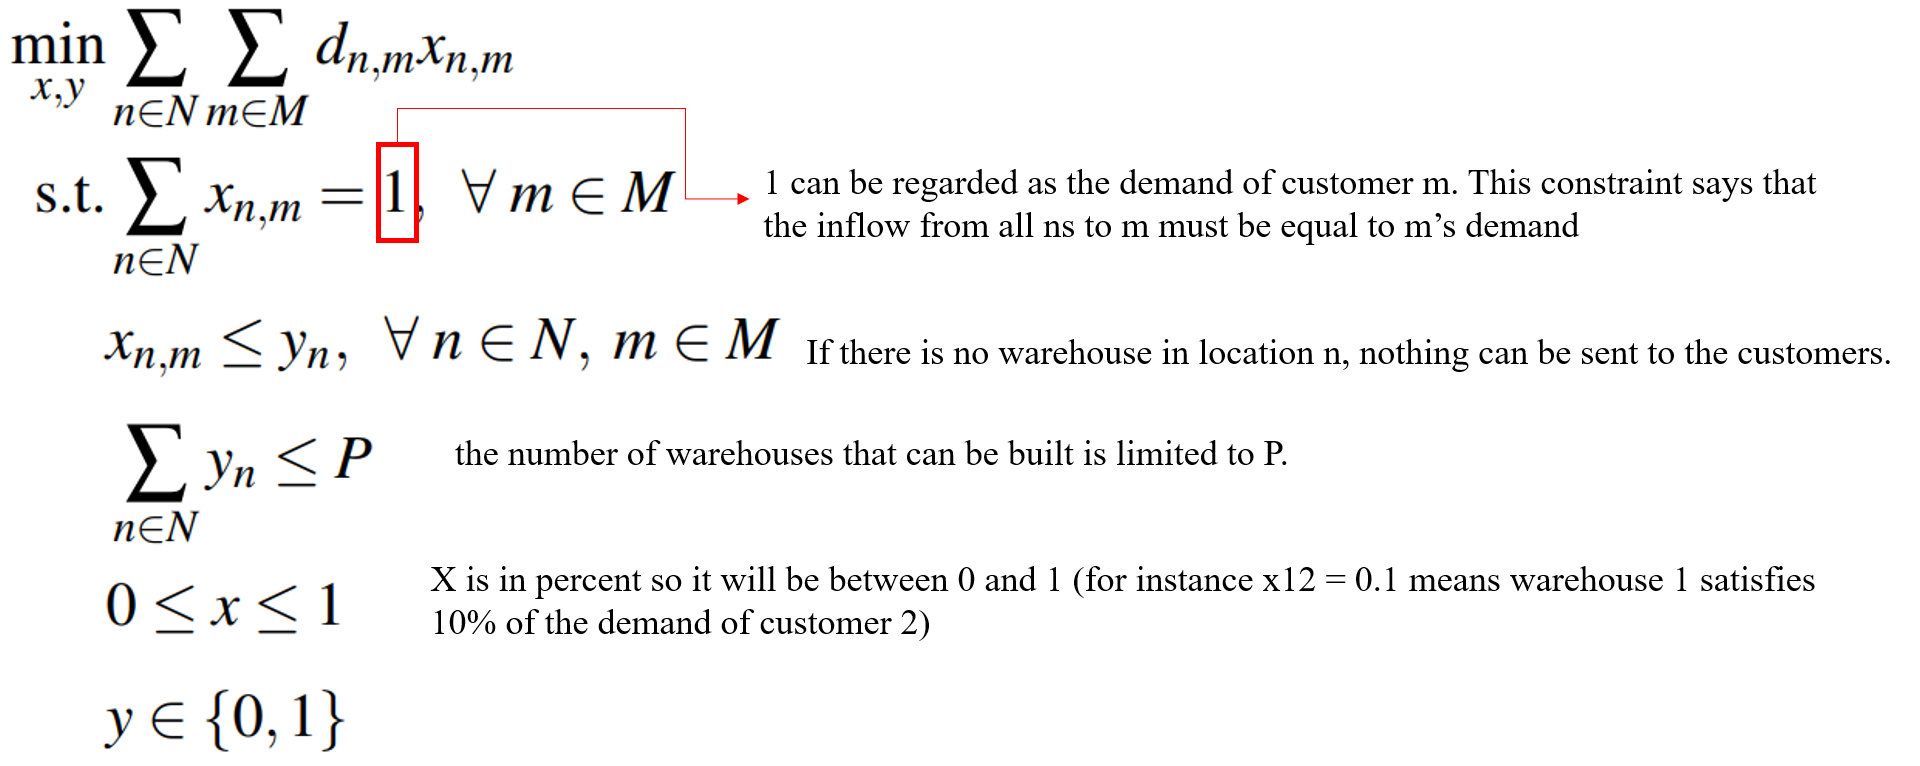

## create an instance of the model

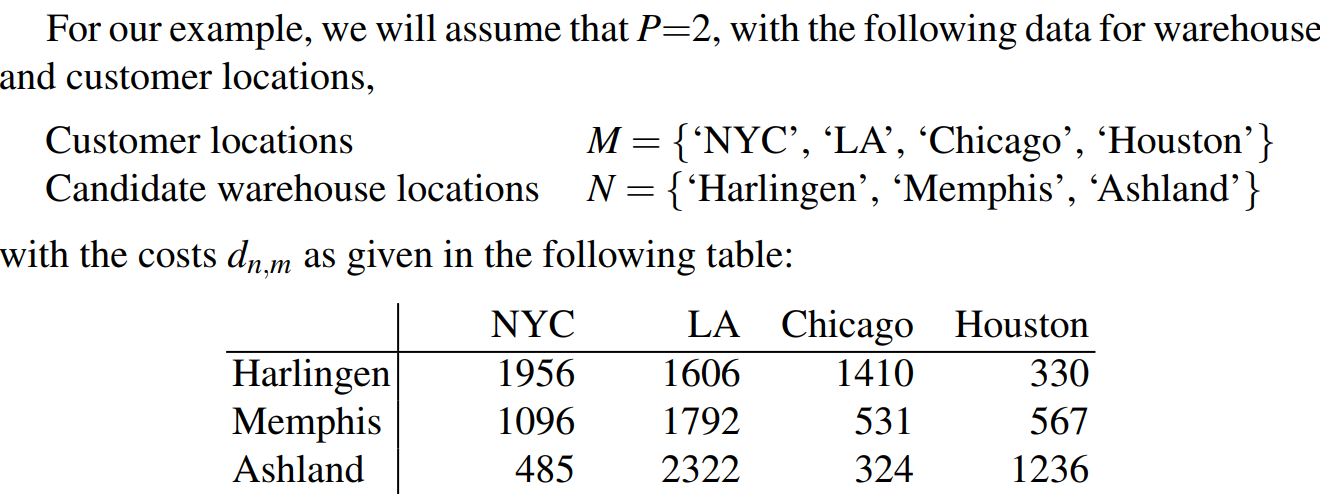

## define the concrete model

In [7]:
def create_warehouse_model(N, M, d, P):
    """
        N: set of candidate warehouse locations
        M: set of customer locations
        d: delivery cost
        P: maximum number of warehouses
    """
    
    model = pyo.ConcreteModel(name="(WL)")
    
    model.x = pyo.Var(N, M, bounds=(0,1))   #percentage of good one wants to send from n to m
    model.y = pyo.Var(N, within=pyo.Binary) # whther warehouse n exists

    def obj_rule(model):
        return sum(d[n,m]*model.x[n,m] for n in N for m in M)
    model.obj = pyo.Objective(rule=obj_rule) # by default the sense is minimization

    def demand_rule(model, m): # for all ms, sum over all ns
        return sum(model.x[n,m] for n in N) == 1
    model.demand = pyo.Constraint(M, rule=demand_rule) # for all ms

    def warehouse_active_rule(model, n, m): # for all ms and ns
        return model.x[n,m] <= model.y[n]
    model.warehouse_active = pyo.Constraint(N, M, rule=warehouse_active_rule)

    def num_warehouses_rule(model):
        return sum(model.y[n] for n in N) <= P
    model.num_warehouses = pyo.Constraint(rule=num_warehouses_rule)
    
    return model

## define specific data to solve the model

In [8]:
N = ["Harlingen", "Memphis", "Ashland"]
M = ["NYC", "LA", "Chicago", "Houston"]

d = {
("Harlingen", "NYC"): 1956,
("Harlingen", "LA"): 1606,
("Harlingen", "Chicago"): 1410,
("Harlingen", "Houston"): 330,
("Memphis", "NYC"): 1096,
("Memphis", "LA"): 1792,
("Memphis", "Chicago"): 531,
("Memphis", "Houston"): 567,
("Ashland", "NYC"): 485,
("Ashland", "LA"): 2322,
("Ashland", "Chicago"): 324,
("Ashland", "Houston"): 1236 }

P = 2

model = create_warehouse_model(N, M, d, P)

In [9]:
solver = pyo.SolverFactory("glpk")
res = solver.solve(model)

print(pyo.check_optimal_termination(res))

True


In [10]:
model.display() #model.pprint()

Model '(WL)'

  Variables:
    x : Size=12, Index=x_index
        Key                      : Lower : Value : Upper : Fixed : Stale : Domain
          ('Ashland', 'Chicago') :     0 :   1.0 :     1 : False : False :  Reals
          ('Ashland', 'Houston') :     0 :   0.0 :     1 : False : False :  Reals
               ('Ashland', 'LA') :     0 :   0.0 :     1 : False : False :  Reals
              ('Ashland', 'NYC') :     0 :   1.0 :     1 : False : False :  Reals
        ('Harlingen', 'Chicago') :     0 :   0.0 :     1 : False : False :  Reals
        ('Harlingen', 'Houston') :     0 :   1.0 :     1 : False : False :  Reals
             ('Harlingen', 'LA') :     0 :   1.0 :     1 : False : False :  Reals
            ('Harlingen', 'NYC') :     0 :   0.0 :     1 : False : False :  Reals
          ('Memphis', 'Chicago') :     0 :   0.0 :     1 : False : False :  Reals
          ('Memphis', 'Houston') :     0 :   0.0 :     1 : False : False :  Reals
               ('Memphis', 'LA') :     0

In [13]:
model.y.pprint()

y : Size=3, Index=y_index
    Key       : Lower : Value : Upper : Fixed : Stale : Domain
      Ashland :     0 :   1.0 :     1 : False : False : Binary
    Harlingen :     0 :   1.0 :     1 : False : False : Binary
      Memphis :     0 :   0.0 :     1 : False : False : Binary


# load required data from Excel

In [2]:
import pandas as pd

In [3]:
data = pd.read_excel("C:/Users/ASUS/Desktop/pyomo_modeling/pyomo_3/data.xlsx", header = 0, index_col = 0)

In [29]:
data

,NYC,LA,Chicago,Houston
Harlingen,1956,1606,1410,330
Memphis,1096,1792,531,567
Ashland,485,2322,324,1236


In [39]:
N = list(data.index)
M = list(data.columns)

d = {(r, c):data.at[r,c] for r in N for c in M}
P = 2

In [40]:
model = create_warehouse_model(N, M, d, P)

solver = pyo.SolverFactory("glpk")
res = solver.solve(model)

print(pyo.check_optimal_termination(res))

True


In [41]:
model.y.pprint()

y : Size=3, Index=y_index
    Key       : Lower : Value : Upper : Fixed : Stale : Domain
      Ashland :     0 :   1.0 :     1 : False : False : Binary
    Harlingen :     0 :   1.0 :     1 : False : False : Binary
      Memphis :     0 :   0.0 :     1 : False : False : Binary


#### for sensitivity analysis, we have two options: 1) put  model = create_warehouse_model(N, M, d, P)  in a for loop and define the whole model at each iteration,  2) define P (considered here as the value we want to perform sensitivity analysis on) as a mutable parameter and change only its value instead of defining the whole model

In [8]:
def create_warehouse_model_new(N, M, d, P):
    mdl = pyo.ConcreteModel(name="(WL)")
    mdl.x = pyo.Var(N, M, bounds=(0,1))
    mdl.y = pyo.Var(N, within=pyo.Binary)
    mdl.P = pyo.Param(initialize=P, mutable=True) #  <================
    
    def obj_rule(mdl):
        return sum(d[n,m]*mdl.x[n,m] for n in N for m in M)
    mdl.obj = pyo.Objective(rule=obj_rule)
    
    def demand_rule(mdl, m):
        return sum(mdl.x[n,m] for n in N) == 1
    mdl.demand = pyo.Constraint(M, rule=demand_rule)
    
    def warehouse_active_rule(mdl, n, m):
        return mdl.x[n,m] <= mdl.y[n]
    mdl.warehouse_active = pyo.Constraint(N, M, rule=warehouse_active_rule)
    
    def num_warehouses_rule(mdl):
        return sum(mdl.y[n] for n in N) <= mdl.P
    mdl.num_warehouses = pyo.Constraint(rule=num_warehouses_rule)
    
    return mdl

In [9]:
N = list(data.index)
M = list(data.columns)

d = {(r, c):data.at[r,c] for r in N for c in M}
P = 2 # parameter will be initialized with this value

In [14]:
model = create_warehouse_model_new(N, M, d, P)

In [15]:
solver = pyo.SolverFactory("glpk")

for n in range(1,10):
    model.P = n
    res = solver.solve(model)
    pyo.assert_optimal_termination(res)
    print(f"# warehouses: {n} |" + f"delivery cost: {pyo.value(model.obj)}")

# warehouses: 1 |delivery cost: 3986.0
# warehouses: 2 |delivery cost: 2745.0
# warehouses: 3 |delivery cost: 2745.0
# warehouses: 4 |delivery cost: 2745.0
# warehouses: 5 |delivery cost: 2745.0
# warehouses: 6 |delivery cost: 2745.0
# warehouses: 7 |delivery cost: 2745.0
# warehouses: 8 |delivery cost: 2745.0
# warehouses: 9 |delivery cost: 2745.0
